In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def custom_breakpointhook(*args, **kwargs):
    from IPython.core.debugger import set_trace; set_trace(*args, **kwargs)
sys.breakpointhook = custom_breakpointhook

In [2]:
def add(path):
    if path not in sys.path:
        sys.path.append(path)
        
if os.environ['USER'] == "dsweet2":
    add("/Users/dsweet2/Projects/yuchen/auction-gym/src")
else:
    add("/Users/yuchenji/PycharmProjects/auction-gym/src")

In [3]:
from main import parse_config, instantiate_agents, instantiate_auction
from ad_auction import AdAuction
from bo_bidder import BOBidder
from const_shading_bidder import ConstShadingBidder

%load_ext autoreload
%autoreload 1
%aimport ad_auction
%aimport bo_bidder
%aimport const_shading_bidder
%aimport main


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
def evaluate(ad_auction, num_iterations):
    trace = []
    for _ in range(num_iterations):
        r = ad_auction.run_episode()
        trace.append(r)
    return np.array(trace).mean()

# Advantage-E

Bidders get an advantage when they shade their bids, i.e. when they bid a little lower than the ad is really worth, because they save money if they win the auction. If they bid *too* low, however, they lose the auction, which is bad because they want the ad slot.

With `config-advantage-E.json` our agent shades it bid w/`EmpiricalShadedBidder` and the other agents bid the true cost (`TruthfulBidder`).

In [5]:
ad_auction = AdAuction("configs/config-advantage-E.json", warm_up_iterations=1000)
print(evaluate(ad_auction, num_iterations=10000))

SEED: 0
0.004258810330345611


The number printed above is our average reward for an episode.

[Actually, it's called "return" when talking about an episode. One step -- in this case, an auction -- yields a reward. When you take many steps in sequence, receiving a reward for each step, you can sum (or average) of the rewards and call it "return".]

In any case, the *return*, here, is `[our net utility - mean(other agent's net utility)] / (mean gross utility)` averaged over the `num_iterations` simulated auctions. The mean gross utility is a mean over all of the agents (including us). It's a measure of the total value generated by the auction -- the total revenue that's up for grabs. That value (i.e., revenue) is split between the bidders and the company that runs the auction.

Since the number returned by `evaluate()` is compared to the other agents in the auctions, we'llrefer to it as our *advantage*.


# TruthfulBidder vs. TO/EO/VO

Now it gets interesting. We bid truthfully (`TruthfulBidder`), and the *other* agents bid either:

- TO: Truthfully, also
- EO: Shading with `EmpiricalShadedBidder`
- VO: Shading with `ValueLearningBidder`

In the first case, TO, we receive exactly zero advantage. The actual number shown below for TO is non-zero b/c the auction process is noisy. That's why we need to run multiple times -- and that's why real auction experiments take so long to run. (And, guess what, Bayesian optimization was made for problems where evaluation takes a long time and is noisy.)

In the other two cases, EO and VO, we have negative advantage. It's better to shade your bid in a smart way than to bid full price all the time.

## Warm-up

Notice the argument `warm_up_iterations`. The tells `AdAuction` how many times to run the auction before doing any evaluation at all. During the warm-up time the learning agents (EO and VO) get a chance to learn about the dynamics of the auction. The auction simulator is interesting in that the agents are aware of each others' behavior via the auction, so they are all learning simultaneously, making bids, and learning even more from observing others' bids. If you look at the plots at the bottom of `auction-gym/src
/Getting Started with AuctionGym (2. Effects of Bid Shading).ipynb` you'll see that it can take a few iterations --each of which consists of many auction rounds -- before the plots settle down. Called a transient, it's there because the agents take time to learn.

We want to do our evaluations after the transient. That will simulate an engineer creating a new ad-bidding bot and trying to optimize it via experiment in an already-functioning ad auction market. Also, it's after the transient that the other agents are at their best.



In [6]:
for ttype in ["TO", "EO", "VO"]:
    ad_auction = AdAuction(f"configs/config-{ttype}.json",  warm_up_iterations=1000)
    print (ttype, evaluate(ad_auction, num_iterations=10000))

SEED: 0
TO -0.0005452502092600794
SEED: 0
EO -0.011657106026253928
SEED: 0
VO -0.0035311654468497353


# Plan

The goal is to optimize a bidder with Bayesian optimization. To do that we need:

1. A way to simulate a sequence of experiments. Done. See above.
2. A parameterized agent.
3. A Bayesian optimizer.


This week, work on step 2.

## BOBidder

We want to optimize parameters by observing rewards (or, in our case, "advantages"). When you optimize this way in RL, it's called *policy search*. If you look in the auction-gym codebase you'll find `PolicyLearningBidder`. That will be our starting point for BOBidder.

To get started, set up an evaluation of a hacked copy of `PolicyLearningBidder`:

- Make a copy of `PolicyLearningBidder` a new file (`bo_bidder.py`) in your Capstone directy.
- Completely remove the method `update()` -- even the signature. You can also remove the code that is referred to as "Option 1". We're only going to use "Option 2". Also, get rid of any references to `gamma` or any other variables that you're not using. `self.model` will be doing the bulk of the work.
- Copy `configs/config-advantage-E.json` to `configs/config-advantage-BO.json`. Inside, replace the `EmpiricalShadedBidder` with `BOBidder`.
- Try to get `evaluate()` to run on your new config file.

It probably won't perform well, but that's because it's not optimized. The first step is just getting it to run.

Next, you'll need to figure our how to get and set the parameters. Create two methods in `BOBidder`:
- `get_parameters(self) -> np.ndarray`, and
- `set_parameters(self, parameters: np.ndarray)`

and make them do the right things.  Fortunately, I have some code lying around that could help. See `ParametersDirect` in `parameters_direct.py`. It should help you get and set the parameters of `self.model`, which is a PyTorch module.


---

# BOBidder Test

Can we instantiate it and generate a bid?

In [7]:
rng = np.random.default_rng(17)
bob = BOBidder(rng)
bob.bid(1, None, .123)   # BOBidder does not use context. Maybe later.

0.10433203393220901

Can we run auctions with it?

In [8]:
extra_classes={'BOBidder': BOBidder}

ad_auction = AdAuction(
    f"configs/config-advantage-BO.json",  warm_up_iterations=10,
    extra_classes=extra_classes  # Let auction_gym know about our new bidder class
)
evaluate(ad_auction, num_iterations=100)

SEED: 0


0.06177991915116345

Now run a full-scale auction evaluation. Our BOBidder will run with randomly-initialized model parameters, and the rest of the bidders will be TruthfulBidders.

In [9]:
ad_auction = AdAuction("configs/config-advantage-BO.json", warm_up_iterations=1000, extra_classes=extra_classes)
print(evaluate(ad_auction, num_iterations=10000))

SEED: 0
0.06151882978200109


Apparently it's even better to shade your bid randomly than to bid truthfully!

## BOBidder vs Constant Bidder

Now create a new class, `ConstShadingBidder` (see `const_shading_bidder.py`), that just shading by a randomly-chosen constant, `gamma`.

We'll have one `BOBidder` compete against a bunch of `ConstShadingBidder`s, and we'll track the advantage of the `BOBidder`.

In [10]:
extra_classes={'BOBidder': BOBidder, 'ConstShadingBidder': ConstShadingBidder}

In [11]:
ad_auction = AdAuction(
    "configs/config-BO-vs-CO.json",
    warm_up_iterations=1,
    extra_classes=extra_classes,  # We need to tell auction_gym about our new bidders
    seed=17
)
print(evaluate(ad_auction, num_iterations=1000))

SEED: 17
ConstShadingBidder: gamma = 0.47384335650314746
ConstShadingBidder: gamma = 0.5525884678082529
ConstShadingBidder: gamma = 0.924251318419947
ConstShadingBidder: gamma = 0.8131539896897586
ConstShadingBidder: gamma = 0.1339331171426752
ConstShadingBidder: gamma = 0.41476587562765754
ConstShadingBidder: gamma = 0.6757789965345686
ConstShadingBidder: gamma = 0.8117210236657704
ConstShadingBidder: gamma = 0.16072071423238365
ConstShadingBidder: gamma = 0.7012552619418484
-0.23723001678964176


Is the result consistent, even though we don't have a fixed seed (i.e., seed='random')?

In [ ]:
print(evaluate(ad_auction, num_iterations=1000))

Yes. They're both around -0.24
With the same set of competitors (the 10 ConstShadingBidder agents) and the same BOBidder, we get approximately the same result, even though the auction process has randomness.

# Optimize it

To optimize our `BOBidder` we need to be able to:

- Propose parameters
- Set the parameters in BOBidder
- Evalute BOBidder with the parameters

You've already implemented the last two steps. We'll implement the first as just random parameter selection to get started. Later, the first step will be a Bayesian optimizer.

First, create an auction, find the `BOBidder`, and display its current parameters.

In [12]:
ad_auction = AdAuction(
    "configs/config-BO-vs-CO.json",
    warm_up_iterations=1,
    extra_classes=extra_classes,  # We need to tell auction_gym about our new bidders
    seed=17
)

bo_bidder = ad_auction.us().bidder
print ("PARAMETERS:", bo_bidder.get_parameters())

SEED: 17
ConstShadingBidder: gamma = 0.47384335650314746
ConstShadingBidder: gamma = 0.5525884678082529
ConstShadingBidder: gamma = 0.924251318419947
ConstShadingBidder: gamma = 0.8131539896897586
ConstShadingBidder: gamma = 0.1339331171426752
ConstShadingBidder: gamma = 0.41476587562765754
ConstShadingBidder: gamma = 0.6757789965345686
ConstShadingBidder: gamma = 0.8117210236657704
ConstShadingBidder: gamma = 0.16072071423238365
ConstShadingBidder: gamma = 0.7012552619418484
PARAMETERS: [-0.01156155 -0.00655526 -0.06522226  0.22283927  0.00949153 -0.13210738
  0.06465603  0.07124017 -0.11474831  0.0535613   0.00689558  0.08203357
  0.07121955 -0.00084424 -0.04082829  0.09103727  0.03131992 -0.14892773
 -0.05448692 -0.04833124 -0.02621545  0.22842921 -0.03772873  0.04773367]


Next, set the parameters to random values.

In [13]:
num_params = len(bo_bidder.get_parameters())
bo_bidder.set_parameters( .1*np.random.normal(size=(num_params,)) )

Now evaluate the `BOBidder` with the randomly-chosen parameters.

In [ ]:
print(evaluate(ad_auction, num_iterations=1000))

To demonstrate optimization, we'll write a simple optimizer that just randomly pertubs the parameters over and over and keeps track of which parameter set performs best.

In [14]:
# Hyperparameters of our simple optimizer
num_rounds = 100
eps = .1

# Initialize the parameters, x_best, to all zeros.

x_best = np.zeros(shape=(num_params,))
y_best = -1e99


In [ ]:
print (f"num_params = {num_params}")
x = x_best
for _ in range(num_rounds):
    # Evaluate the current x
    bo_bidder.set_parameters(x)
    y = evaluate(ad_auction, num_iterations=1000)
    
    # Keep track of the best so far
    if y > y_best:
        y_best = y
        x_best = x
    
    # Propose a new x that is a small perturbation
    #  of the best x.
    x = x_best + eps*np.random.normal(size=(num_params,))
    print (f"EVAL: y_best = {y_best:.4f} y = {y:.4f} x = {x[0]:.2f}, {x[1]:.2f}, ...")

That's not bad for optimization by random perturbations.
Can we do better with Bayesian optimization? We'll find out.

# Bayesian Optimization

Please read through SKOpt's Bayesian optimization library [documentation](https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html) and see if you can apply `gp_minimize()` to this problem.

NB: The algorithm `gp_minimize()` minimizes -- hence the name :) -- but we want to *maximize* the output of `evaluate()`, so just pass the arithmetic inverse of the advantage, `-evaluate()`, to `gp_minimize()`, and it'll perform a maximization.



In [7]:
pip install scikit-optimize

Note: you may need to restart the kernel to use updated packages.


In [15]:
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
import numpy as np

In [ ]:
num_params = 24
param_space = [Real(-1.0, 1.0, name=f'param{i}') for i in range(num_params)]

best_advantage = None
best_round = 0
iteration_count = 0  # Counter for iterations

@use_named_args(param_space)
def objective(**params):
    global best_advantage, best_round, iteration_count

    # Increment iteration count
    iteration_count += 1

    # Convert parameter dictionary to array
    param_values = np.array(list(params.values()))
    
    # Update BOBidder's parameters
    bo_bidder.set_parameters(param_values)
 
    # Run the auction and compute the advantage
    advantage = evaluate(ad_auction, num_iterations=1000)
    print(f"Evaluating with params: {param_values}")

    # Update best advantage and round if this is the best we've seen
    current_advantage = -advantage
    if best_advantage is None or current_advantage > best_advantage:
        best_advantage = current_advantage
        best_round = iteration_count

    # Since gp_minimize minimizes the function, return the negative advantage
    return -advantage

# Perform Bayesian Optimization
result = gp_minimize(objective, param_space, n_calls=100, random_state=17)

# Best parameter values and advantage found
print("Best parameters: {}".format(result.x))
print("Best advantage: {}".format(best_advantage))
print("Best advantage achieved in round: {}".format(best_round))

It achieved a best performance of 0.5408. This result is better than the best performance of the simple random optimizer.

# Emulating a Real-world Scenario


When running an ad-bidding strategy, you will be concerned with your advantage (or utility or revenue) every day that you run your strategy. The days with "experimental" parameters are just as important as any other day. Everything counts. The scenario looks like this:

- Day 1: Run a bidding strategy, as proposed by BO, benefit from your advantage
- Day 2: Run a bidding strategy, as proposed by BO, benefit from your advantage
- Day 3: Run a bidding strategy, as proposed by BO, benefit from your advantage
- ...
- Day n: Run a bidding strategy, as proposed by BO, benefit from your advantage

Your score is the sum of all n advantages. Because every day of your business counts, not just the best day.

Knowing that everything counts, we should consider the cumulative advantage, i.e. the sum of the advantages of all of the days during which the strategy runs. In the work above, we just tracked y_best. From here on in, let's track y_sum.

In terms of the random optimizer:

In [16]:
ad_auction = AdAuction(
    "configs/config-BO-vs-CO.json",
    warm_up_iterations=1,
    extra_classes=extra_classes,  # We need to tell auction_gym about our new bidders
    seed=17
)

bo_bidder = ad_auction.us().bidder

num_params = len(bo_bidder.get_parameters())
num_rounds = 100
eps = .1


x_best = np.zeros(shape=(num_params,))
y_best = -1e99
y_total = 0

SEED: 17
ConstShadingBidder: gamma = 0.47384335650314746
ConstShadingBidder: gamma = 0.5525884678082529
ConstShadingBidder: gamma = 0.924251318419947
ConstShadingBidder: gamma = 0.8131539896897586
ConstShadingBidder: gamma = 0.1339331171426752
ConstShadingBidder: gamma = 0.41476587562765754
ConstShadingBidder: gamma = 0.6757789965345686
ConstShadingBidder: gamma = 0.8117210236657704
ConstShadingBidder: gamma = 0.16072071423238365
ConstShadingBidder: gamma = 0.7012552619418484


In [ ]:
print (f"num_params = {num_params}")
x = x_best
for i_iter in range(num_rounds):
    # Evaluate the current x
    bo_bidder.set_parameters(x)
    y = evaluate(ad_auction, num_iterations=1000)
    y_total += y
    
    # Keep track of the best so far
    if y > y_best:
        y_best = y
        x_best = x
    
    # Propose a new x that is a small perturbation
    #  of the best x.
    x = x_best + eps*np.random.normal(size=(num_params,))
    print (f"EVAL: {i_iter} y_total = {y_total:.4f} y = {y:.4f} x = {x[0]:.2f}, {x[1]:.2f}, ...")

The metric of interest is `y_total`. Notice how we incur a cost of a while as the system optimizes, then we earn it back, then we are "profitable" (in terms of total advantage).

You should modify your `gp_minimize()` code to track the total advantage, then run a series of experiments comparing the different acquisition functions available in `gp_minimize()` via the argument `acq_func`. They are `LCB`, `EI`, `PI`, and a novel one called `gp_hedge`, which forms an adaptive ensemble from the other three.

For each experiment, you should measure `y_total` for each acquisition function for a total of 84 rounds, to emulate `[7 days/week] X [4 weeks/month] X [3 months] = 84 days`. We're imagining that we update the advertising parameters every day for three months.

You should replicate each experiment 10 times, each time passing a different seed to `AdAuction`. To make your experiments easy to repliate, your seeds should be systematically chosen (ex., seed = replication number). To make the comparisons between acquisition functions have lower variability (noise), you should use the same set of seeds for each acquisition function. For example, you could write a loop like:

```
def run_experiment(acq_func):
    for i_replication in range(10):
        ad_auction = AdAuction(..., seed = i_replication)
        gp_minimize(..., acq_func=acq_func)
        ...
```

In other words, the seed is different for each replication, but for a given `i_replication`, the seed is the same for all `acq_func`s.


    

In [20]:
from my_functions import run_single_replication
from skopt import gp_minimize
from multiprocessing import Pool

In [21]:
# Define the parameter space
num_params = 24
param_space = [Real(-1.0, 1.0, name=f'param{i}') for i in range(num_params)]


# Objective function
@use_named_args(param_space)
def objective(**params):
    param_values = np.array(list(params.values()))
    bo_bidder.set_parameters(param_values)
    advantage = evaluate(ad_auction, num_iterations=1000)
    return -advantage

#  Run the experiment using multiprocessing
def run_experiment(acq_func):
    with Pool(10) as p:
        args = [(acq_func, i) for i in range(10)]
        result_files = p.map(run_single_replication, args)

    # Collect results from files
    y_totals = []
    for file_name in result_files:
        with open(file_name, "r") as file:
            data = json.load(file)
            y_totals.append(data["y_total"])
            os.remove(file_name)

    avg_total_advantage = np.mean(y_totals)
    return avg_total_advantage

In [22]:
# Main experiment loop
acquisition_functions = ['LCB', 'EI', 'PI', 'gp_hedge']
results = {}

for acq_func in acquisition_functions:
    results[acq_func] = run_experiment(acq_func)

# Print the results
for acq_func, avg_advantage in results.items():
    print(f"Acquisition Function: {acq_func}, Average Total Advantage: {avg_advantage}")

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_m

NameError: name 'AdAuction' is not defined


Finally, a common and helpful was to present results like this is in a plot of `y_total` vs. `round` (or "day"). The plot should show the mean over the replications as well as either the standard error across the replications.

Here is a plot in that style. It only has three rounds and compares many acquisition functions. Also it shows the max measured value instead of the cumulative measured value. The plot is the right style, just for a different project.

If you need help creating the plot, let me know. I have functions written to do this.

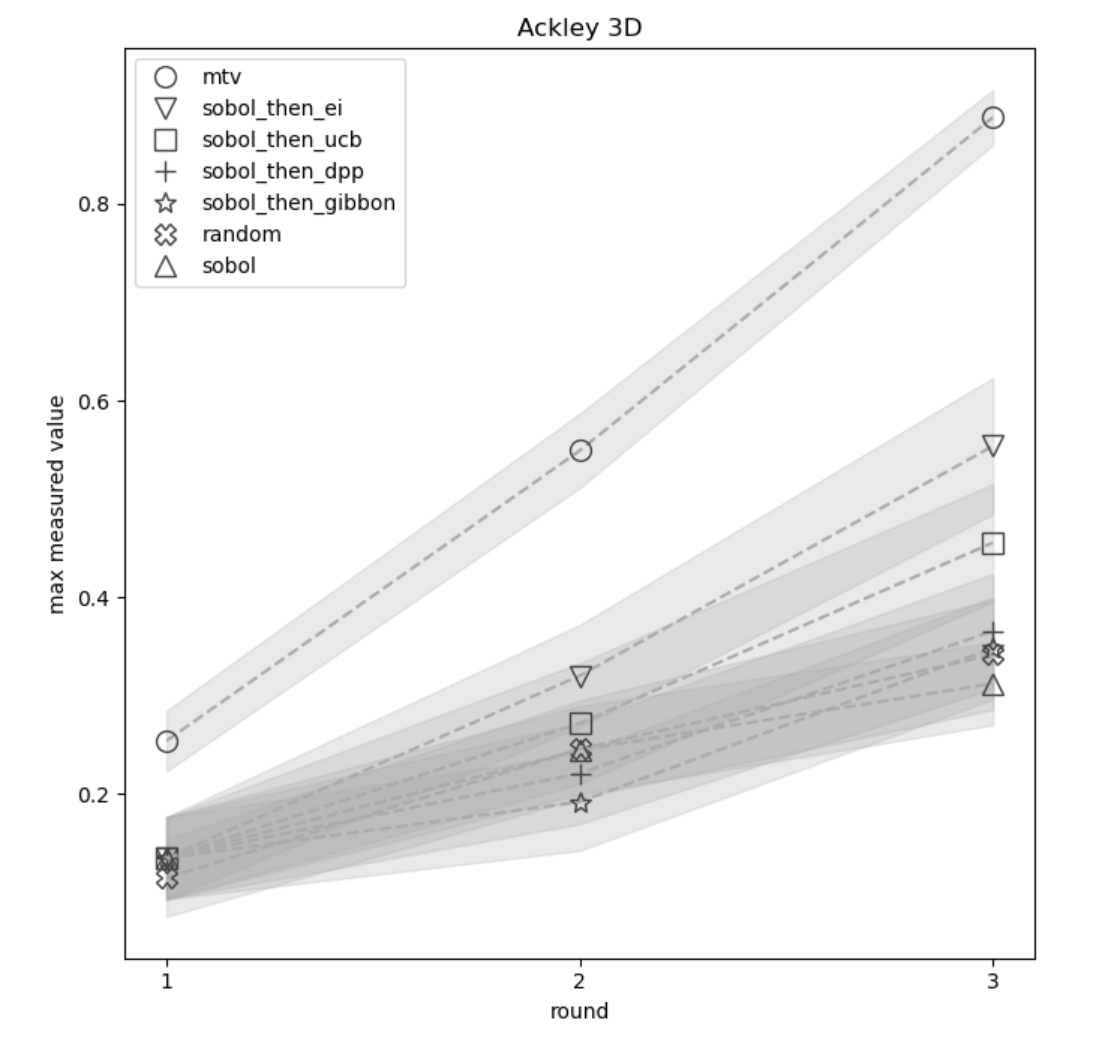

You should write your paper in an academic style. Good advice is here: https://www.jakobfoerster.com/how-to-ml-paper

I have been using the LaTeX editor [Overleaf](https://www.overleaf.com) recently, but you are free to use any tools that you like.

You should start with a LaTeX template that you like. For example, this one from JMLR https://github.com/JmlrOrg/jmlr-style-file.  There are similar templates from other journals and Overleaf has a gallery of templates.


Your paper should describe the real-world problem, tell why Bayesian optimization is a good way to solve it, give some background on Bayesian optimization and how it works, explain how the ad auction simulator simulates the real-world problem, describe your experimental method(s), present your results (your plot), discuss/interpret your results (i.e., How do you relate to the real-world problem?), and then conclude.

In [ ]:
/